Importing Libraries

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans

%matplotlib inline

Loading the data

In [2]:
df = pd.read_csv('Australian_Road_Deaths.csv')

# Part A

## Q1) How many rows and columns exist in this dataset?

In [3]:
df.shape

(9140, 22)

There are 9140 rows, and 22 columns in this data set.

## Q2) Count the number of unique values for National Remoteness Areas, SA4 Name 2016, National LGA Name 2017, and National Road Type in this dataset.

In [4]:
# Copy the original dataframe
q2_df = copy.deepcopy(df)

# Get the required column names in a single dataframe
q2_df = df[["National Remoteness Areas", "SA4 Name 2016", "National LGA Name 2017", "National Road Type"]]

# Get a description of dataframe along with the unique values in it
q2_df.describe()

# uniqueValues.nunique()

,National Remoteness Areas,SA4 Name 2016,National LGA Name 2017,National Road Type
count,6892,6906,6907,6891
unique,5,88,500,9
top,Major Cities of Australia,Western Australia - Wheat Belt,Central Coast,National or State Highway
freq,2375,231,92,2024


The number of unique values are,
1. **National Remoteness Areas** : 5
2. **SA4 Name 2016** : 88
3. **National LGA Name 2017** : 900
4. **National Road Type** : 9

## Q3) Missing values and duplicates

### Q3-1) How many rows contain missing values (Unspecified or Undetermined or blank) in this dataset? 

In [5]:
#n_missing = sum([True for idx, row in df.iterrows() if any(row.isnull())])

# Since finding null values is non-destructive, we do not need to make a new copy of dataframe
q3_df = df.isnull().any(axis=1).sum()

print(f'{q3_df} rows contain unspecified, undetermined or blank values in this dataset.')

2287 rows contain unspecified, undetermined or blank values in this dataset.


### Q3-2) List the months with no missing values in them.

In [6]:
# Create a deepcopy of original dataframe
q3_2_df = copy.deepcopy(df)

# Converting the YYYYMM column to yyyy-mm-dd format
_temp = pd.to_datetime(q3_2_df['YYYYMM'].astype(str), format='%Y%m')
q3_2_df.insert(3, 'Month', _temp.dt.month_name().str[:3])
q3_2_df.insert(3, 'Year', _temp.dt.year);

In [7]:
# list of years
yr_ = np.arange(2014, 2022, 1)

# list of months
months_ = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

is_not_null = []

# iterating over months and years
for i in yr_:
    for j in months_:
        df_ = q3_2_df[(q3_2_df['Year'] == i) & (q3_2_df['Month'] == j)]
        is_not_null.append([i, j, df_.notnull().values.all()])

In [8]:
no_null_month = pd.DataFrame(is_not_null, columns=['Year', 'Month', 'No Null Value'])

no_null_month[no_null_month['No Null Value'] == True].reset_index(drop=True)

,Year,Month,No Null Value
0,2018,Apr,True
1,2018,Nov,True
2,2019,Feb,True
3,2019,Jul,True
4,2019,Oct,True
5,2019,Nov,True
6,2021,Oct,True
7,2021,Nov,True
8,2021,Dec,True


The table above lists the months in various years that do not have any null value in them. Most months with no null values occured in **2019**. **October** and **November** are two months that do not have null values **twice** in this dataset.

### Q3-3) Remove the records with missing values.

In [9]:
q3_3_df = q3_2_df.dropna()

### Q3-4) Remove duplicates as well after removing the missing values.

Using the **q3_3_df** dataframe to remove the duplicates as it **already has missing values removed**.

In [10]:
df_dropduplicates = q3_3_df.drop_duplicates()

## Q4) List the number of crashes in each month. In which two months are the number of crashes at their largest?

In [11]:
# Note: Use the dataset with missing values and duplicates removed from here onwards.

# Get a fresh copy of original dataframe that has missing and duplicate values
q4_df = copy.deepcopy(df)

# Split the YYYYMM into year-month again
_temp = pd.to_datetime(q4_df['YYYYMM'].astype(str), format='%Y%m')
q4_df.insert(3, 'Month', _temp.dt.month_name().str[:3])
q4_df.insert(3, 'Year', _temp.dt.year);

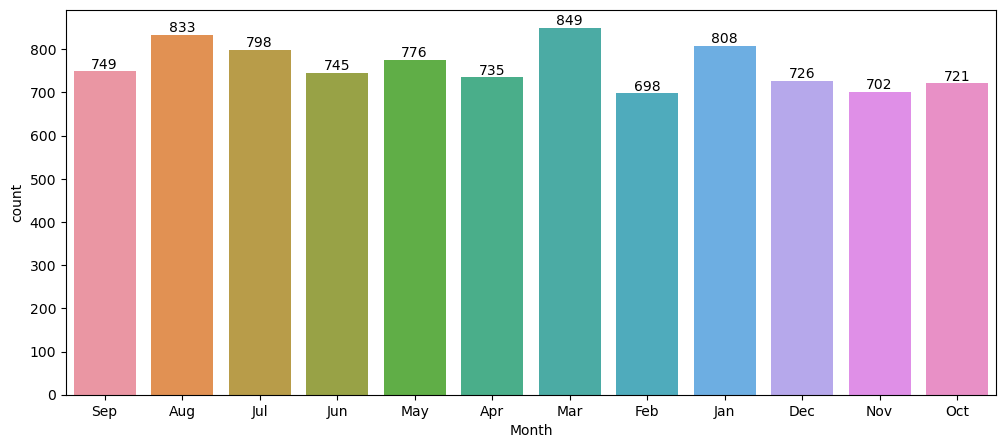

In [12]:
f, ax = plt.subplots(1, 1, figsize=(12, 5))
bar_plot = sns.countplot(data=q4_df, x='Month', ax=ax)
bar_plot.bar_label(bar_plot.containers[0]);

As we can see that most accidents happened in the month of **March, 849**.

After that, we have **August** at second place with **833** reported accidents.

We can also see the **number of accidents in a listed form**, as shown below,

In [13]:
# for j in yr_:
#     print(f'Year = {j}')
#     print([(i, len(_temp['Month'][(_temp['Month'] == i) & (_temp['Year'] == j)])) for i in months_])

[(i, len(q4_df['Month'][q4_df['Month'] == i])) for i in months_]

[('Jan', 808),
 ('Feb', 698),
 ('Mar', 849),
 ('Apr', 735),
 ('May', 776),
 ('Jun', 745),
 ('Jul', 798),
 ('Aug', 833),
 ('Sep', 749),
 ('Oct', 721),
 ('Nov', 702),
 ('Dec', 726)]

## Q5)  Investigating crashes over different months for specific road user

### Q5-1) Compute the average number of crashes against Month for `car drivers`

#### Extract the year, month column separately

The year and month column is already extracted with `q4_df`. I'll use a copy of that dataframe as it is the same as original dataframe but with added `Year`, `Month` column.

In [14]:
# Make a new copy of `q4_df`
q5_df = copy.deepcopy(q4_df)

#### Compute the number of crashes by both `Year` and `Month` for `car drivers`.

In [15]:
# Get the required columns.
# The `Road User` column is required to get the `Car passenger` category

q5_1_df = q5_df[['Year', 'Month', 'Road User']]
q5_1_df = q5_1_df[q5_1_df['Road User'] == 'Car passenger']

In [16]:
q5_1_df__year = q5_1_df[['Year', 'Road User']].groupby('Year').agg('count')
q5_1_df__year.columns = ['Car passengers']
q5_1_df__year = q5_1_df__year.T
q5_1_df__year = q5_1_df__year[yr_]  # Rearranging the dataframe columns
q5_1_df__year

Year,2014,2015,2016,2017,2018,2019,2020,2021
Car passengers,228,252,208,235,204,206,188,132


The table above shows the number of accidents per year of `Road User` with category as `Car passenger`.

In [17]:
q5_1_df__month = q5_1_df[['Month', 'Road User']].groupby('Month').agg('count')
q5_1_df__month.columns = ['Car passengers']
q5_1_df__month = q5_1_df__month.T
q5_1_df__month = q5_1_df__month[months_]  # Rearranging the dataframe columns
q5_1_df__month

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Car passengers,157,102,135,140,146,113,162,165,142,127,119,145


The table above shows the number of accidents per month over the years of `Road User` with category as `Car passenger`.

#### Based on task A5-1-b result, compute again the average number of crashes against Month. For each month, the average number of crashes is calculated over different years for which we have collected data for.

In [18]:
# Getting the number of accidents per year per month from the data
_temp = [[len(q5_1_df[(q5_1_df['Month'] == j) & (q5_1_df['Year'] == i)])
          for j in months_] for i in yr_]

# Taking mean along the year axis
accident_avg = np.mean(np.array(_temp), axis=0)

### Q5-2) Draw a chart showing the average number of crashes over different months computed in task A5-1

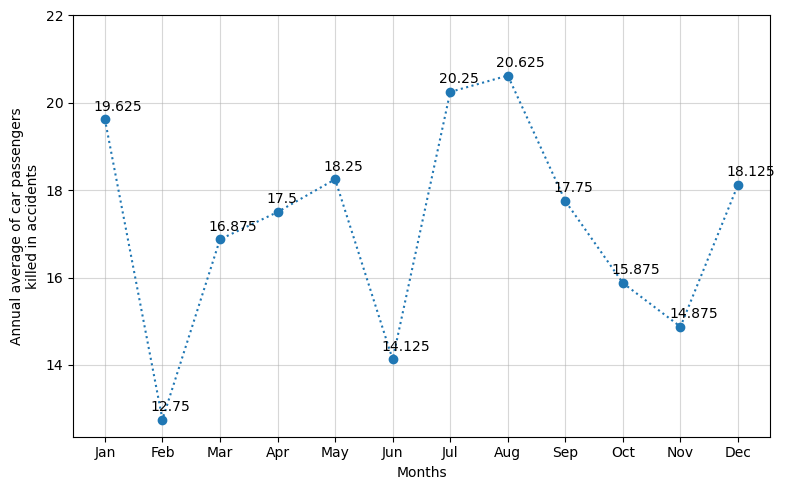

In [19]:
# Plotting the data retrieved from A5-1
plt.figure(figsize=(8, 5))
plt.grid('on', alpha=0.5)

plt.plot(months_, accident_avg, 'o', ls=':')
plt.xlabel('Months')
plt.ylabel('Annual average of car passengers\nkilled in accidents')

for i, v in enumerate(accident_avg):
    plt.annotate(v, (i-0.2, v+0.2))

plt.ylim(top=22)
plt.tight_layout()

### Q5-3) Discuss any interesting point in the chart.

1. The average accidents for `Car passengers` are not that high in `March` even though it has the most reported accidents overall. However, the most reported `Car passenger` accidents are in `August` which has second highest reported accident cases overall.
2. `February` has the lowest number of accidents reported for `Car passengers`.
3. The accidents drop from `August` to `November` steadily and than rise again.
4. With an exception of `June`, the trend from `February` to `August` is a rising one.

## Q6) Exploring Speed, National Road Type, and Age

## Q6-1) Draw a chart showing the average speed against National Road Type for car drivers

In [20]:
# Make a copy of `q4_df`
q6_1_df = copy.deepcopy(q4_df)

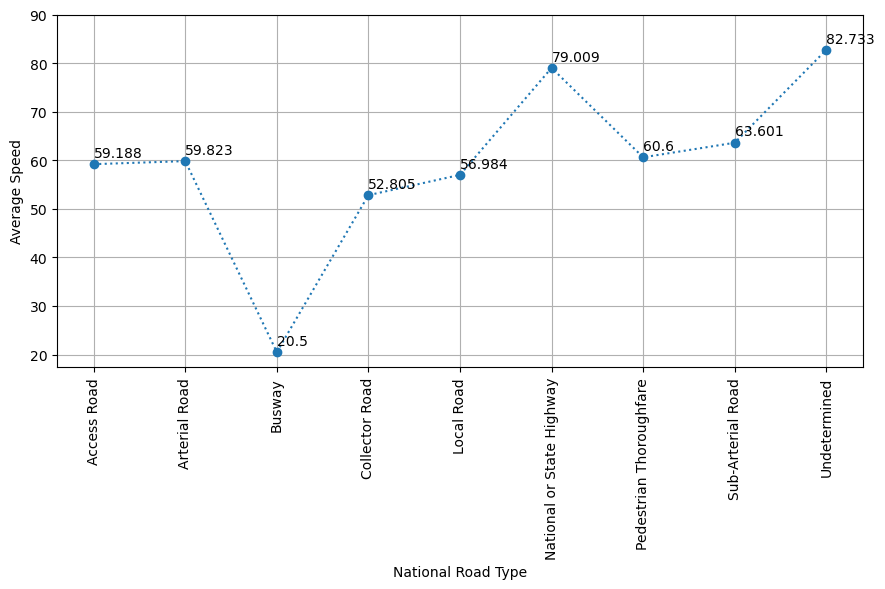

In [21]:
_temp = q6_1_df[['National Road Type', 'Speed']].groupby('National Road Type').mean('Speed').reset_index()

plt.figure(figsize=(9, 6))
plt.grid('on')

plt.plot(_temp['National Road Type'], _temp['Speed'], 'o:')

for i, v in enumerate(_temp['Speed']):
    plt.annotate(np.round(v, 3), (i, v+1.5))

plt.xticks(rotation = 90);
plt.ylabel('Average Speed')
plt.xlabel('National Road Type')
plt.ylim(top=90)
plt.tight_layout()

## Q6-2) Due to measurement error, there are some counter-intuitive values in Age column. Identify those values and replace them with zero.

In [22]:
# Identifying the error values in `Age` column
err_ = q6_1_df[q6_1_df[['Age', 'Age Group']]['Age'] < 0]

# Get the indices of the rows with erronous `Age` parameter
print(err_.index)

Int64Index([  40,   90,  162,  738, 1653, 1654, 1655, 1656, 3146, 3147, 3699,
            4166, 5204, 7702, 8434, 8490],
           dtype='int64')


The indices above contain data where the `Age` parameter has been erronously filled.

In [23]:
# Get the values that have been filled errounously in the data
print(list(err_['Age']))

[-999, -999, -9, -9, -9, -9, -9, -9, -9, -9, -9, -9, -999, -999, -9, -9]


`pd.clip` function can be used to clip these values off to 0.

In [24]:
# Clip the negative values to 0
q6_1_df['Age'] = q6_1_df['Age'].clip(lower=0)

In [25]:
# Verifying that all the values for `Age` parameters at the error indices are now 0.
list(q6_1_df.loc[err_.index]['Age'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Q7) Relationship between Age, Speed, and Driving Experiences

### Q7-1) Compute pairwise correlation of columns, Age, Speed, and Driving Experiences for vehicle drivers (such as Motorcycle rider). Which two features have the highest linear association?

**Note**: Use the dataset from previous task (Task A6) and complete Tasks, A7-A9.

In [26]:
# make a copy of `q6_1_df` dataframe
q7_df = copy.deepcopy(q6_1_df)

As we need correlations related to all the `Road User` values, the first thing to do is to get the unique values for them.

In [27]:
# Get unique values
ruser = list(np.unique(q7_df['Road User']))

# The `ruser` contain values that are not "vehicle drives",
# These values should also be removed
[ruser.remove(i) for i in ['Car passenger', 'Motorcycle pillion Car passenger', 'Pedal cyclist', 'Pedestrian']]

_temp = q7_df[['Age', 'Speed', 'Driving experience', 'Road User']]
corr = [_temp[_temp['Road User'] == i].corr() for i in ruser]

In [28]:
for i, j in zip(ruser, corr):
    print(f'Road User = {i}\n')
    print(f'Correlations; \n {j}')
    print('\n')

Road User = Car driver

Correlations; 
                          Age     Speed  Driving experience
Age                 1.000000  0.008019            0.947057
Speed               0.008019  1.000000            0.005472
Driving experience  0.947057  0.005472            1.000000


Road User = Motorcycle rider

Correlations; 
                          Age     Speed  Driving experience
Age                 1.000000 -0.017874            0.916216
Speed              -0.017874  1.000000           -0.012161
Driving experience  0.916216 -0.012161            1.000000


Road User = Other vehicle driver

Correlations; 
                          Age     Speed  Driving experience
Age                 1.000000 -0.008394            0.938338
Speed              -0.008394  1.000000            0.041687
Driving experience  0.938338  0.041687            1.000000




In all cases for `Road User` values, the `Age` and `Driving experience` parameters show strong correlation.

## Q7-2) Now let's look at the relationship between the number of crashes and Driving Experiences. 

This exercise can be done using two methods,
1. With histogram
    1. By calculating the number of crashes via `pandas` masking, and plotting via `matplotlib`.
    2. By using `seaborn.histplot`.
2. With scatter plot

In [29]:
# Get the dataframe correct by selecting only those rows that have,
# Car driver, Motorcycle rider, Other vehicle driver as values
q7_2_df = q7_df[np.isin(q7_df, ruser).any(axis=1)]
q7_2_df.reset_index(drop=True, inplace=True)

In [30]:
# Verify
np.unique(q7_2_df['Road User'])

array(['Car driver', 'Motorcycle rider', 'Other vehicle driver'],
      dtype=object)

#### Pandas and Matplotlib histogram

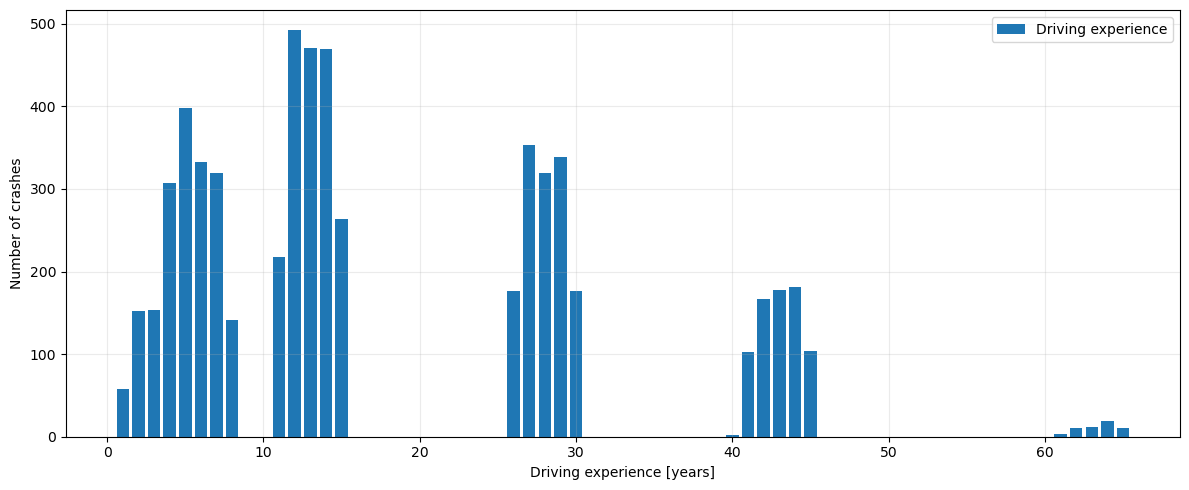

In [31]:
# Number of crashes using `pandas` and `matplotlib`.
d_exp = np.unique(q7_2_df['Driving experience'])
n_crash = [len(q7_2_df[q7_2_df['Driving experience'] == i]) for i in d_exp]

f, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.grid('on', alpha=0.25)
ax.bar(d_exp, n_crash, label='Driving experience')
ax.set_xlabel('Driving experience [years]')
ax.set_ylabel('Number of crashes')
plt.legend(loc='best')
plt.tight_layout()

#### Seaborn histogram

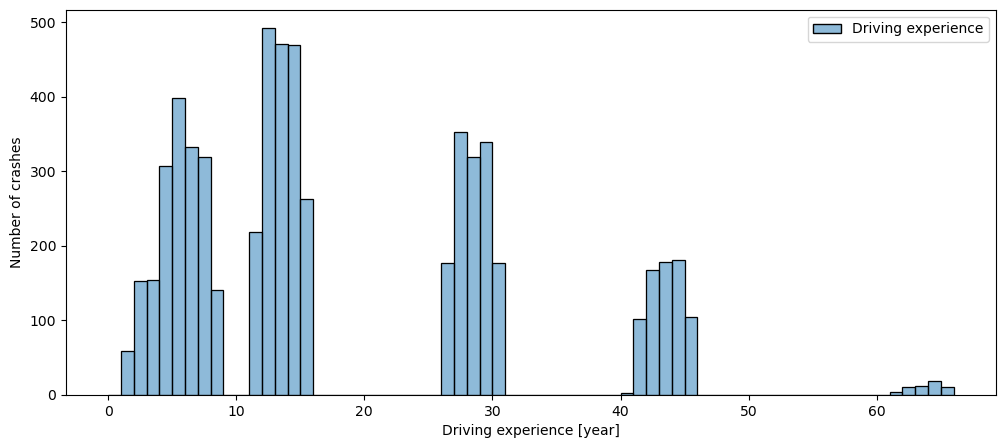

In [32]:
# Number of crashes using `seaborn.histplot`
_temp2 = q7_2_df[['Driving experience']]

f, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.histplot(_temp2, bins=range(0, 67), ax=ax)
ax.set_ylabel('Number of crashes')
plt.xlabel('Driving experience [year]');

#### Matplotlib scatterplot

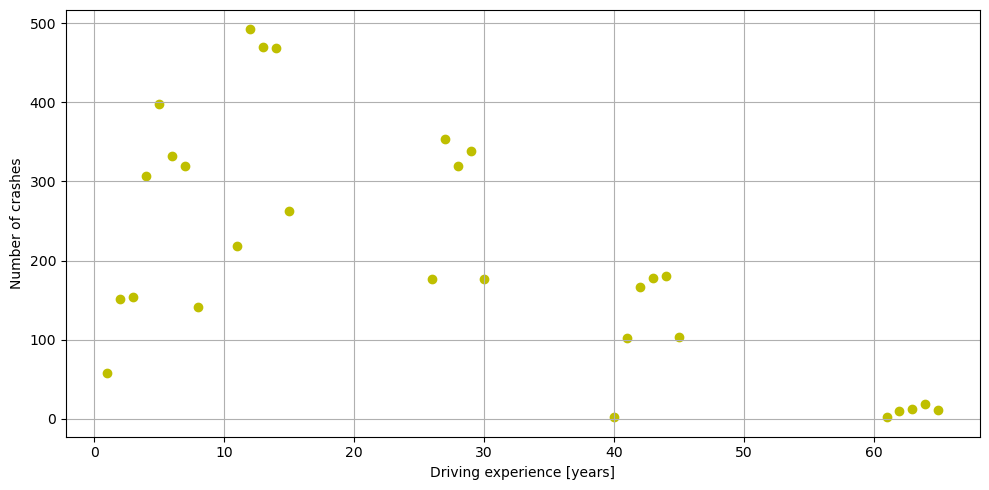

In [33]:
crash_dict = _temp2.value_counts().to_dict()

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.scatter(crash_dict.keys(), crash_dict.values(), c='y', marker='o')
plt.xlabel('Driving experience [years]')
plt.ylabel('Number of crashes')
plt.tight_layout()

1. Generally, with an **increase** in driving experience, people seem to be having **lesser accidents** overall.
2. It can also be seen that the middle part of the histogram age group has most tendency to get into accidents.

## Q8) Investigating yearly trend of crash

In [34]:
# Get a fresh copy of dataframe
q8_df = copy.deepcopy(q6_1_df)

Compute the number of crashes per year by using `value_counts` function from `pandas` library.

In [35]:
year_crash_df = pd.DataFrame(q8_df['Year'].value_counts()).reset_index()
year_crash_df.columns = ['Year', '# of Crashes']

year_crash_df

,Year,# of Crashes
0,2016,1292
1,2017,1227
2,2015,1207
3,2019,1190
4,2014,1151
5,2018,1133
6,2020,1093
7,2021,847


## Q8-1) Fit a linear regression using Python to this data

Plotting the data for visualization

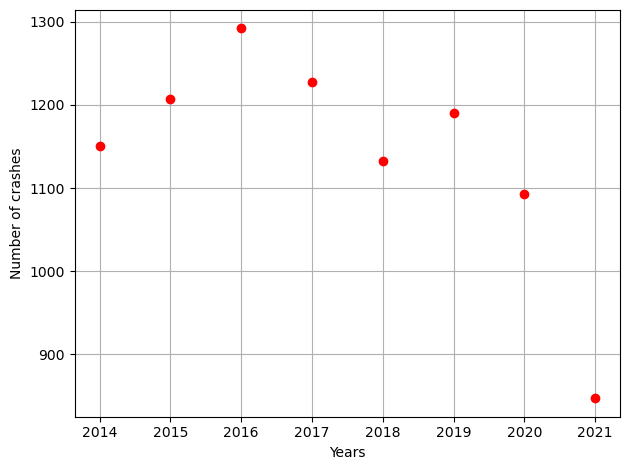

In [36]:
plt.grid('on')
plt.plot(year_crash_df['Year'], year_crash_df['# of Crashes'], 'ro');
plt.xlabel('Years')
plt.ylabel('Number of crashes')
plt.tight_layout();

Performing a linear regression using `scipy.stats.linregression`.

In [37]:
slope, intercept, _, _, _ = scipy.stats.linregress(year_crash_df['Year'], year_crash_df['# of Crashes'])
line = [slope*i + intercept for i in yr_]

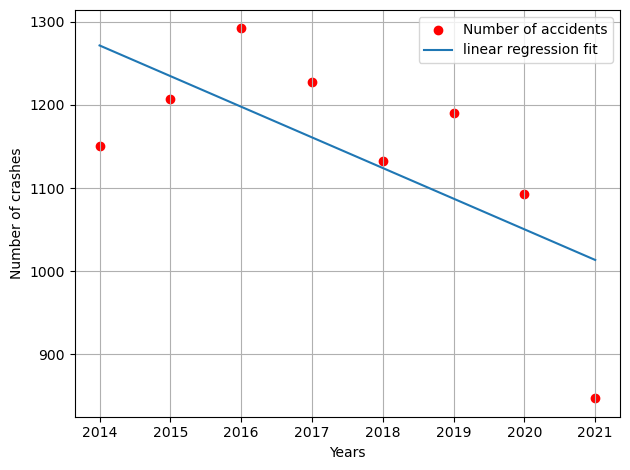

In [38]:
plt.grid('on')

plt.scatter(year_crash_df['Year'], year_crash_df['# of Crashes'], c='r', label='Number of accidents')
plt.plot(yr_, line, label='linear regression fit');

plt.xlabel('Years')
plt.ylabel('Number of crashes')
plt.legend(loc='best')
plt.tight_layout()

## Q8-2) Use the linear fit to predict the number of crashes in 2022

A linear regression was calculated in Q8-1). The same will be used for the prediction of crashes in 2022.

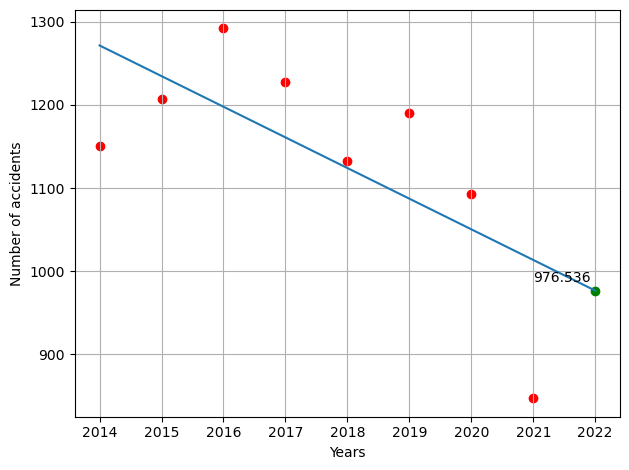

In [39]:
# Increasing yr_ to include 2022 as well,
yr2_ = list(yr_)
yr2_.append(2022)

# Calculating the line from slope and intercept again
line2 = [slope*i + intercept for i in yr2_]


plt.grid('on')
plt.scatter(year_crash_df['Year'], year_crash_df['# of Crashes'], c='r', marker='o', label='Number of accidents')
plt.plot(yr2_[-1], line2[-1], 'go')
plt.plot(yr2_, line2)
plt.annotate(round(line2[-1], 3), (yr2_[-1]-1, line2[-1] + 10));
plt.xlabel('Years')
plt.ylabel('Number of accidents')
plt.tight_layout()

The linear regression predicts that for the year 2022, 976 accidents can happen.

## Q8-3) Can you think of a better model that well captures the trend of yearly crash? Develop a new model and explain why it is better suited for this task.

Since the data is rising and falling, a better fit to the data can be a normal distribution. Using `scipy.stats.norm`, the data can be fitted easily. The normal distribution covers all points from the higher ups to the low ones as well, this is why I think a normal distribution will be a better fit for this data.

In [40]:
norm, std = scipy.stats.norm.fit(year_crash_df['Year'])

### Q8-4) Use your new model to predict the number of crashes in 2022.

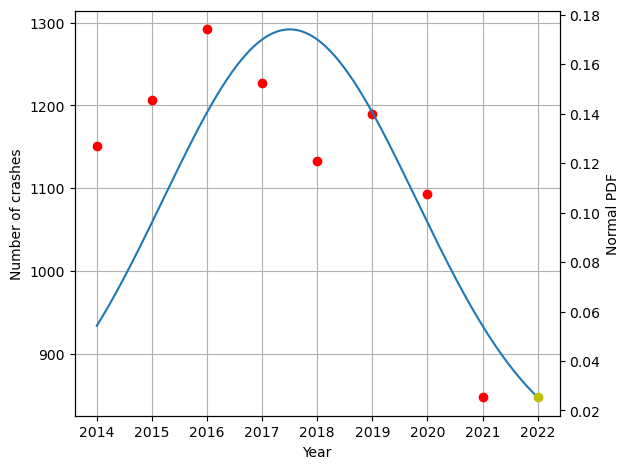

In [41]:
# Get the data
x = np.array(year_crash_df['Year'])
y = np.array(year_crash_df['# of Crashes'])

# sort the data
x_, y_ = [np.array(i) for i in zip(*sorted(zip(x, y)))]

x_pred = np.linspace(x_.min(), x_.max()+1, 1000)


n_pdf = scipy.stats.norm.pdf(x_pred, norm, std)

# Plot the data and the model
f, ax = plt.subplots(1, 1)
plt.grid('on')

ax.plot(x_, y_, 'ro')

tx = ax.twinx()


tx.plot(x_pred, n_pdf)
tx.plot(x_pred[-1], n_pdf[-1], 'yo')

ax.set_ylabel('Number of crashes')
ax.set_xlabel('Year')
tx.set_ylabel('Normal PDF')
plt.tight_layout()

The new model fitted predicts that the number of accidents in `2022` will be `closer to the number of accidents` that happened in `2021`

## Q9) Rather than replacing some counter-intuitive values with zero in task A6, use a better (e.g., modelbased) approach to fill in the counter-intuitive values.

For the predictions of age, we first need the data that had the age values missing. i.e, `q4_df`

In [42]:
# Make a copy
q9_df = copy.deepcopy(q4_df)

In [43]:
q9_df['Age Group'].isnull().any()

True

An issue with this data set is that it is missing some `Age Group` values as well. So, we drop those values.

In [44]:
q9_df = q9_df[q9_df['Age Group'].notna()]
q9_df.reset_index(drop=True, inplace=True)

Now, let's see what age groups do we have.

In [45]:
q9_df[q9_df['Age'] < 0]['Age Group']

40      40_to_64
90      40_to_64
5194     0_to_16
7692    65_to_74
Name: Age Group, dtype: object

So, there are 2 values missing from `40_to_64`, 1 from `0_to_16` and 1 from `65_to_74`. To predict the ages, `LinearRegression` from `sklearn` library will be used.

In [46]:
# Function to get the predictive ages
def get_age_values(_df):
    test_data = _df[_df['Age'] < 0]
    train_data = _df[_df['Age'] > 0]

    x_train = train_data[['Speed']]
    y_train = train_data[['Age']]

    lr = LinearRegression()
    lr.fit(x_train, y_train)
    
    x_test = test_data['Speed']
    x_test = pd.DataFrame(x_test)
    
    return np.floor(np.array(lr.predict(x_test)).flatten())

In [47]:
# Separating the age groups
pd_00to16 = q9_df[q9_df['Age Group'] == '0_to_16']
pd_40to64 = q9_df[q9_df['Age Group'] == '40_to_64']
pd_65to75 = q9_df[q9_df['Age Group'] == '65_to_74']

In [48]:
# Getting the age values from the predictive model
vals1 = get_age_values(pd_00to16)
vals2 = get_age_values(pd_40to64)
vals3 = get_age_values(pd_65to75)

In [49]:
vals1, vals2, vals3

(array([9.]), array([51., 51.]), array([69.]))

So the predicted age in the age group of `0_to_16` is `9`. Both the missing ages from `40_to_64` age group are calculated to be `51`, where as the value missing in `65_to_74` age group came out to be `69`.

# Part-B1

# Decision Tree Classification on Song Popularity Dataset and K-means Clustering on Other Data

Read the data into a variable, and clean it up by removing the duplicate values if they exist.

In [50]:
sdata = pd.read_csv('song_data.csv')

sdata = sdata.drop_duplicates()
sdata.reset_index(inplace=True)

Keep a copy, for safekeeping.

In [51]:
orig = copy.deepcopy(sdata)

Dropping few not-needed columns, and storing the `song_popularity` into another variable.

Let's see the correlations first to get an idea of what columns should be picked.

In [52]:
sdata.corr()

,index,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
index,1.000000,-0.104198,-0.044311,-0.052298,0.068787,0.049866,0.042978,0.017364,0.000646,0.090375,-0.072950,0.064443,-0.000005,0.000577,-0.074769
song_popularity,-0.104198,1.000000,-0.006919,-0.032647,0.053833,-0.015113,-0.090165,-0.002170,-0.034314,0.052607,0.007052,0.000600,-0.024645,0.023037,-0.044289
song_duration_ms,-0.044311,-0.006919,1.000000,-0.113820,-0.089205,0.096875,-0.025525,-0.006534,0.020954,0.028614,-0.028230,-0.079338,0.013774,0.005530,-0.069465
acousticness,-0.052298,-0.032647,-0.113820,1.000000,-0.172948,-0.679798,0.179552,-0.000949,-0.085703,-0.570429,0.059611,-0.085451,-0.144247,-0.153009,-0.128045
danceability,0.068787,0.053833,-0.089205,-0.172948,1.000000,0.054728,-0.125088,0.008166,-0.094284,0.174165,-0.098346,0.200974,-0.127419,0.136648,0.350088
energy,0.049866,-0.015113,0.096875,-0.679798,0.054728,1.000000,-0.222068,0.014362,0.176281,0.765920,-0.048955,0.072149,0.182729,0.144481,0.315984
instrumentalness,0.042978,-0.090165,-0.025525,0.179552,-0.125088,-0.222068,1.000000,-0.008393,-0.040253,-0.398995,-0.019001,-0.077082,-0.041688,-0.067056,-0.198091
key,0.017364,-0.002170,-0.006534,-0.000949,0.008166,0.014362,-0.008393,1.000000,-0.002718,0.008014,-0.175160,0.028683,-0.004800,-0.007503,0.023343
liveness,0.000646,-0.034314,0.020954,-0.085703,-0.094284,0.176281,-0.040253,-0.002718,1.000000,0.112186,-0.000879,0.093895,0.026070,0.014198,0.016848
loudness,0.090375,0.052607,0.028614,-0.570429,0.174165,0.765920,-0.398995,0.008014,0.112186,1.000000,-0.055801,0.078447,0.140722,0.112558,0.210589


Although no parameter is strongly correlated but there are some that are negatively correlated. For this feature selection purpose, they'll be dropped off.

In [53]:
sdata = sdata[['song_popularity', 'danceability', 'loudness', 'audio_mode', 'speechiness']]

The target `song_popularity` is to be predicted using other features. For this, the `X` dataset should not contain this parameter.

In [54]:
X = sdata.drop(['song_popularity'], axis=1)
y = pd.DataFrame(sdata['song_popularity'])

## B1-1) Divide the data set into a 75% training set and a 25% testing set using only the features relevant for classification

Splitting the data into `train` and `test` on 75% and 25% respectively.

In [55]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=100)

## B1-2) Use feature scaling and train a decision tree model.

For feature scaling, I use three scalars from `sklearn`.
1. StandardScalar
2. RobustScalar
3. Normalizer

In [56]:
std_scalar = StandardScaler()
rbst_scalar = RobustScaler()
nrml_scalar = Normalizer()

Time to train and test the data using the three selected scalars.

In [57]:
train_X__std_scalar = std_scalar.fit_transform(train_X)
train_X__std_scalar = pd.DataFrame(train_X__std_scalar, columns=X.columns)
test_X__std_scalar = std_scalar.transform(test_X)
test_X__std_scalar = pd.DataFrame(test_X__std_scalar, columns=X.columns)

In [58]:
train_X__rbst_scalar = rbst_scalar.fit_transform(train_X)
train_X__rbst_scalar = pd.DataFrame(train_X__rbst_scalar, columns=X.columns)
test_X__rbst_scalar = rbst_scalar.transform(test_X)
test_X__rbst_scalar = pd.DataFrame(test_X__rbst_scalar, columns=X.columns)

In [59]:
train_X__nrml_scalar = nrml_scalar.fit_transform(train_X)
train_X__nrml_scalar = pd.DataFrame(train_X__nrml_scalar, columns=X.columns)
test_X__nrml_scalar = nrml_scalar.transform(test_X)
test_X__nrml_scalar = pd.DataFrame(test_X__nrml_scalar, columns=X.columns)

Defining a function that gives out the accuracy score and confusion matrix for the trained and test data.

In [60]:
def acc_conf(_trainX, _testX, _trainY=train_y, _testY=test_y):
    clf = tree.DecisionTreeClassifier()
    clf.fit(_trainX, _trainY)
    y_pred = clf.predict(_testX)
    return accuracy_score(test_y, y_pred)*100, confusion_matrix(_testY, y_pred)

def g_print(acc, cmat):
    print(f'{acc=}')
    print(f'{cmat=}')

## B1-3) Discuss your findings from the confusion matrix and accuracy. You should consider other performance metrics you learnt in lecture 7 to answer this question. 

Let's check the accuracy of model with data that doesn't has a scalar transformation on it.

In [61]:
acc, cmat = acc_conf(train_X, test_X, train_y, test_y)
g_print(acc, cmat)

acc=28.967933171651843
cmat=array([[ 51,  89, 150, 133,   7],
       [ 84, 118, 261, 169,  14],
       [153, 310, 601, 381,  36],
       [108, 191, 423, 300,  26],
       [ 10,  20,  47,  24,   5]])


Now, with **standard scalar** method.

In [62]:
acc, cmat = acc_conf(train_X__std_scalar, test_X__std_scalar)
g_print(acc, cmat)

acc=28.887092427917004
cmat=array([[ 53,  94, 148, 126,   9],
       [ 83, 116, 264, 170,  13],
       [167, 299, 595, 388,  32],
       [105, 178, 436, 302,  27],
       [ 10,  15,  52,  23,   6]])


Next up, we have **Robust Scalar** method.

In [63]:
acc, cmat = acc_conf(train_X__rbst_scalar, test_X__rbst_scalar)
g_print(acc, cmat)

acc=28.563729452977633
cmat=array([[ 56,  89, 153, 124,   8],
       [ 76, 115, 258, 180,  17],
       [171, 304, 588, 382,  36],
       [107, 178, 439, 297,  27],
       [ 12,  18,  44,  28,   4]])


And finally, we have **Normalizer** method.

In [64]:
acc, cmat = acc_conf(train_X__nrml_scalar, test_X__nrml_scalar)
g_print(acc, cmat)

acc=27.836162759364054
cmat=array([[ 45,  94, 156, 119,  16],
       [ 82, 135, 241, 172,  16],
       [155, 273, 585, 426,  42],
       [131, 177, 441, 266,  33],
       [ 17,  15,  43,  29,   2]])


From the above runs, all four models have an accuracy of ~29%. With the `StandardScalar` being ~29%.

# Part B2

## QB2-1) Provide the direct link to the public dataset from the internet

The data is taken from the following link

https://www.kaggle.com/datasets/aryashah2k/credit-card-customer-data

Load the dataset

In [65]:
customer_data = pd.read_csv('credit_card_data.csv')

Let's only keep unique customers, by removing any duplicates if exist in the `Customer Key` column.

In [66]:
customer_data = customer_data.drop_duplicates(subset='Customer Key', keep='last')
customer_data.reset_index(drop=True, inplace=True)

For further analysis, let's drop the **serial number key**.

In [67]:
customer_data = customer_data.drop('Sl_No', axis=1)

For the selection of two numerical features, let's see the clustering within `Avg_Credit_Limit` and `Total_Credit_Cards`.

In [68]:
customer_ = customer_data[['Avg_Credit_Limit', 'Total_Credit_Cards']]

Let's use the `Standard` and `Robust` scalar methods for classification.

In [69]:
std_scalar = StandardScaler()
rbst_scalar = RobustScaler()

Defining a function for the value of inertia and the transformed data to be generated from both scalar transformations.

In [83]:
def get_inertia(scalar_, data):
    X = scalar_.fit_transform(data)
    in_ = []
    for i in range(2, 10):
        km = KMeans(n_clusters=i, init='random', random_state=50)
        km.fit(X)
        in_.append(km.inertia_)
        
    return X, in_

In [84]:
std_X, std_inertia = get_inertia(std_scalar, customer_)
rbst_X, rbst_inertia = get_inertia(rbst_scalar, customer_)

Plotting the `number of KM clusters` vs the `inertia parameter` from the clustering.

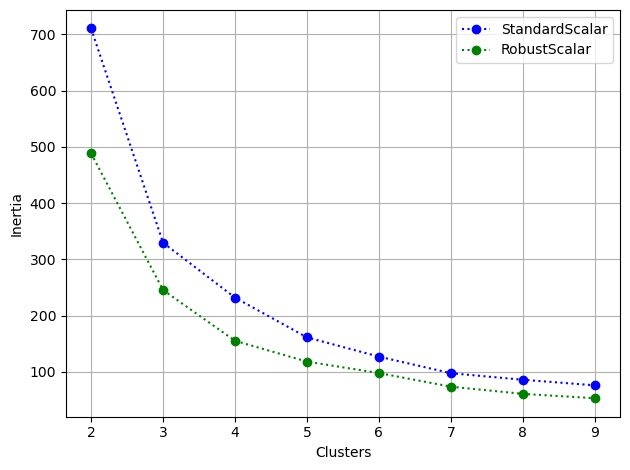

In [85]:
plt.plot(range(2, 10), std_inertia, 'bo:', label='StandardScalar')
plt.plot(range(2, 10), rbst_inertia, 'go:', label='RobustScalar')
plt.grid('on')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.legend(loc='best')
plt.tight_layout()

The elbow for the KMeans cluster seems to be around 3. So, let's keep the cluster number to 3. It can be seen that the inertia for the `RobustScalar` is lesser than `StandardScalar`. Clustering the data with the elbow.

Let's define a function to get the `centroid values` and the `KM fit` parameter as well.

In [86]:
def get_centroids(clusters_, data):
    km = KMeans(n_clusters=3, init='random', random_state=50)
    km.fit(data)
    centroids = km.cluster_centers_
    
    return km, centroids

In [87]:
std_km, std_centroids = get_centroids(3, std_X)
rbst_km, rbst_centroids = get_centroids(3, rbst_X)

And finally, a function for the plotting of the data.

In [88]:
def plot_(data, KMean, centroids, scalar_name):
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.scatter(data[KMean.labels_ == 0, 0], data[KMean.labels_ == 0, 1], c='green', s=3, label='cluster 1')
    plt.scatter(data[KMean.labels_ == 1, 0], data[KMean.labels_ == 1, 1], c='blue', s=3,  label='cluster 2')
    plt.scatter(data[KMean.labels_ == 2, 0], data[KMean.labels_ == 2, 1], c='orange', s=3,  label='cluster 3')
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=30, c='red', label='centroid')
    plt.legend()
    plt.title(f'Visualization of clustered data\nwith {scalar_name} method', fontweight='bold')
    ax.set_aspect('equal');

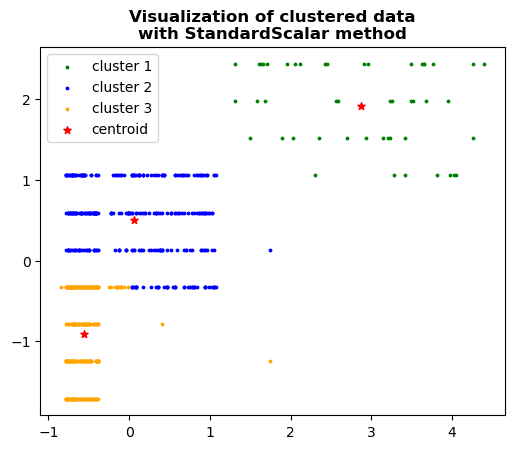

In [89]:
plot_(std_X, std_km, std_centroids, 'StandardScalar')

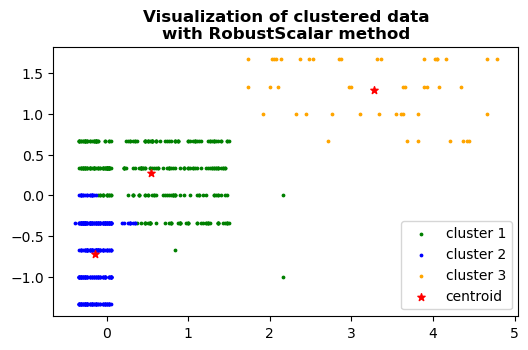

In [90]:
plot_(rbst_X, rbst_km, rbst_centroids, 'RobustScalar')

1. It can be seen that the centroids with the `RobustScalar` are placed differently than those of `StandardScalar`.
2. There are two outlying points from `cluster2` from `StandardScalar` that have shifted twoards `cluster` in `RobustScalar`. 
3. The bottom left cluster `cluster2` for `RS` contains more data points than `cluster3` from `SS`.